# Метод ближайших соседей

Разберёмся как тренировать модели машинного обучения и, в частности, метод ближайших соседей в sklearn.

![](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style='dark')

### Генерация данных

Сгенерируем данные

In [2]:
np.random.seed(13)
n = 100
a = np.random.normal(loc=0, scale=1, size=(n, 2))
b = np.random.normal(loc=3, scale=2, size=(n, 2))

Визуализируем полученный набор данных

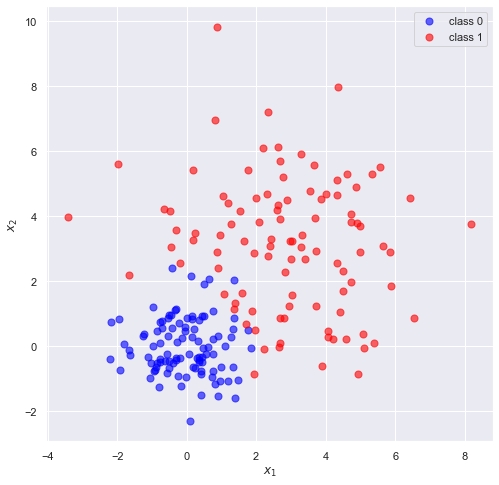

In [3]:
plt.figure(figsize=(8, 8))

plt.scatter(a[:, 0], a[:, 1], c='blue', s=50, alpha=0.6)
plt.scatter(b[:, 0], b[:, 1], c='red', s=50, alpha=0.6)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid()
plt.legend(['class 0', 'class 1'], loc='upper right');

Объединим матрицы в единую матрицу данных и создадим отдельный столбец меток класса

In [4]:
X = np.vstack([a, b])
y = np.hstack([np.zeros(n), np.ones(n)])

X.shape, y.shape

((200, 2), (200,))

Для визуализации воспользуемся следующий палитрой:

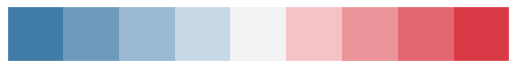

In [5]:
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.palplot(sns.diverging_palette(240, 10, n=9))

Можно визуализировать одной командой scatter

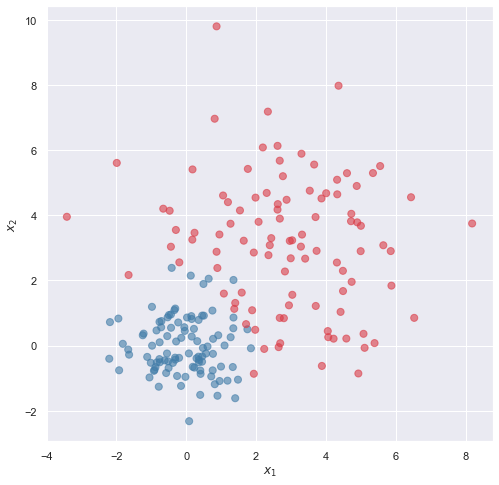

In [6]:
plt.figure(figsize=(8, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, alpha=0.6, cmap=cmap)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid()

## Обучение моделей

Попробуем обучить разные варианты [метода ближайших соседей](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) из scikit-learn:

```python
class KNeighborsClassifier(...):
    def __init__(self, n_neighbors=5,
                 weights='uniform', algorithm='auto', leaf_size=30,
                 p=2, metric='minkowski', metric_params=None, n_jobs=None,
                 **kwargs):
```

Для начала обучим метод 3 ближайших соседей

In [7]:
from sklearn.neighbors import KNeighborsClassifier as KNN
clf = KNN(n_neighbors=3)
clf.fit(X, y)
clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Предскажем метки для каких-нибудь точек

In [8]:
X_test = [
    [2, 0],
    [10, 20],
    [-10, -20]
]
clf.predict(X_test)

array([1., 1., 0.])

Предскажем вероятности каждой из меток

In [9]:
clf.predict_proba(X_test)

array([[0.33333333, 0.66666667],
       [0.        , 1.        ],
       [1.        , 0.        ]])

А что, если мы хотим помотреть, как обученный алгоритм проводит разделяющую поверхность между объектами из признакового пространства?

Для начала напишем функцию для генерации карты точек

In [10]:
def get_grid(data, border=1.0, step=0.01):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step),
                       np.arange(y_min, y_max, step))

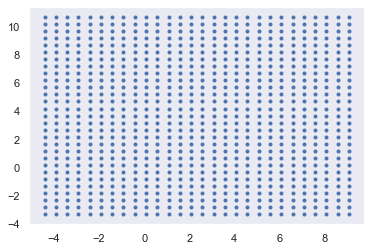

In [11]:
xx, yy = get_grid(X, step=0.5)
plt.plot(xx, yy, 'b.');

Примерним классификатор к карте точек и визуализируем её

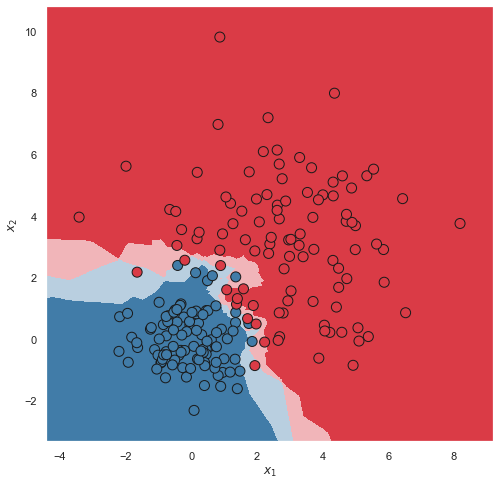

In [12]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(8, 8))
xx, yy = get_grid(X)
predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

plt.pcolormesh(xx, yy, predicted, cmap=cmap)
plt.scatter(X[:, 0], X[:, 1], c=y, s=100., edgecolor='k', cmap=cmap)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

Обернём все вышеописанное (обучение + предсказание + визуализацию) в одну функцию

In [13]:
def plot_model(X, y, clf):
    clf.fit(X, y)
    xx, yy = get_grid(X)
    predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    plt.axis('equal')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    plt.pcolormesh(xx, yy, predicted, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, edgecolors='k', cmap=cmap, alpha=0.7)

Будем перебирать параметр "число соседей" и визуализировать полученное разбиение пространства объектов

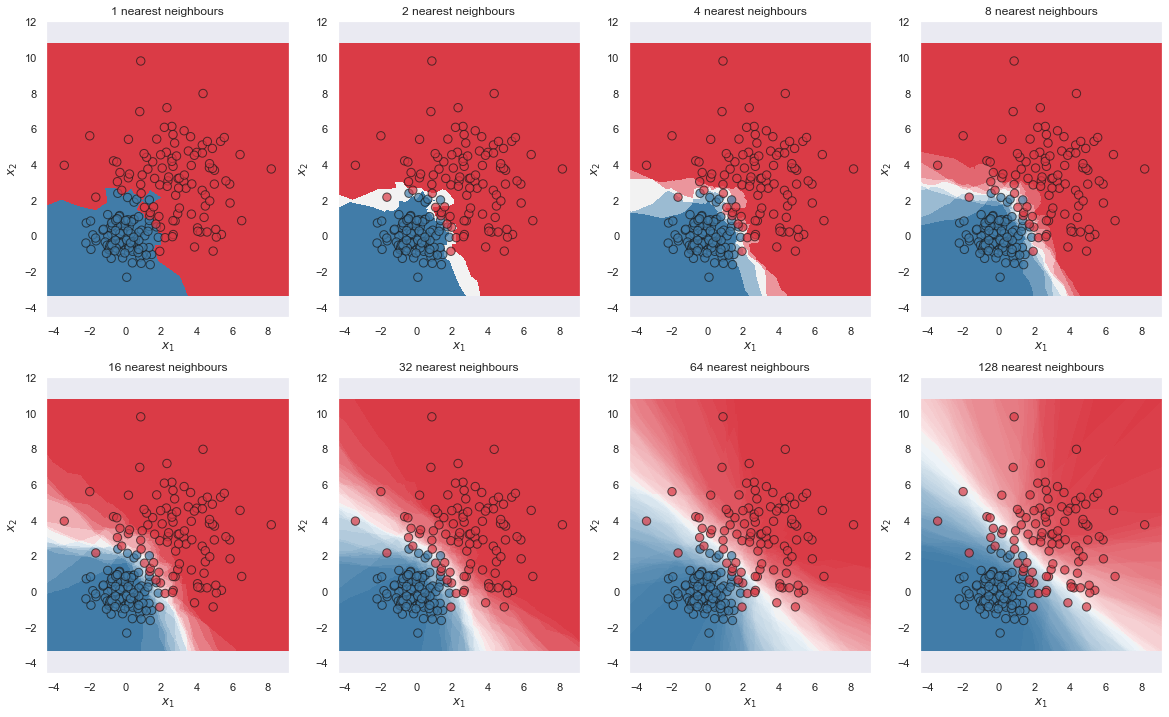

In [14]:
plt.figure(figsize=(20, 12))
for index, n_neighbors in enumerate(np.logspace(0, 7, 8, base=2, dtype=np.int16)):
    plt.subplot(2, 4, index + 1)
    plot_model(X, y, KNN(n_neighbors=n_neighbors))
    plt.title(f'{n_neighbors} nearest neighbours')

## Как выбрать число соседей?

### Оценка качества

Разобьём данные на 2 части: обучение и контроль

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(140, 2) (140,)
(60, 2) (60,)


Оценим качество работы для n_neighbors=3

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, KNN(n_neighbors=3).fit(X_train, y_train).predict(X_test))

0.9333333333333333

Оценим качество для каждого из значений n_neighbors из [1, n) и построим график зависимости качества от n_neighbors

In [18]:
n = 100
scores = []
for k in range(1, n):
    scores.append(accuracy_score(y_test, KNN(n_neighbors=k).fit(X_train, y_train).predict(X_test)))

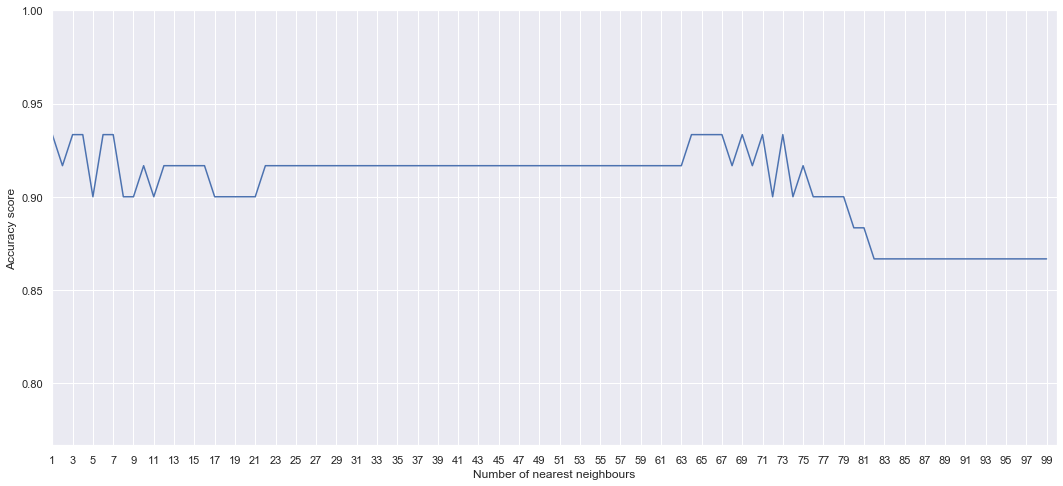

In [19]:
plt.figure(figsize=(18, 8))
plt.plot(range(1, n), scores)
plt.xlim(1, n)
plt.ylim(np.min(scores) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

Из-за небольшого количества данных в тесте график получается шумным, и не до конца ясно, какое число соседей оптимально. Проведем кроссвалидацию средствами библиотеки sklearn

In [20]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, n)}
grid_searcher = GridSearchCV(clf, params, cv=5)
grid_searcher.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=3, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': range(1, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Визуализируем полученные оценки качества и их $1\sigma$-доверительный интервал

In [21]:
df = pd.DataFrame(grid_searcher.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000497,0.000277,0.001761,0.000711,1,{'n_neighbors': 1},0.900,0.900,0.950,0.950,0.975,0.935,0.030000,26
1,0.000283,0.000028,0.001343,0.000143,2,{'n_neighbors': 2},0.925,0.925,0.950,0.950,0.950,0.940,0.012247,22
2,0.000293,0.000040,0.001408,0.000175,3,{'n_neighbors': 3},0.925,0.950,0.950,0.950,0.975,0.950,0.015811,5
3,0.000282,0.000026,0.001354,0.000189,4,{'n_neighbors': 4},0.925,0.925,0.975,0.975,0.975,0.955,0.024495,2
4,0.000281,0.000031,0.001255,0.000038,5,{'n_neighbors': 5},0.925,0.975,0.975,0.950,0.975,0.960,0.020000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.000223,0.000025,0.001504,0.000074,95,{'n_neighbors': 95},0.825,0.875,0.925,0.925,0.875,0.885,0.037417,90
95,0.000205,0.000002,0.001521,0.000041,96,{'n_neighbors': 96},0.800,0.850,0.925,0.925,0.875,0.875,0.047434,97
96,0.000208,0.000005,0.001501,0.000024,97,{'n_neighbors': 97},0.825,0.850,0.925,0.925,0.875,0.880,0.040000,95
97,0.000205,0.000002,0.001503,0.000016,98,{'n_neighbors': 98},0.800,0.825,0.925,0.900,0.875,0.865,0.046368,98


In [22]:
means = df['mean_test_score']
stds = df['std_test_score']
n_neighbors = df['params'].apply(lambda x: x['n_neighbors'])

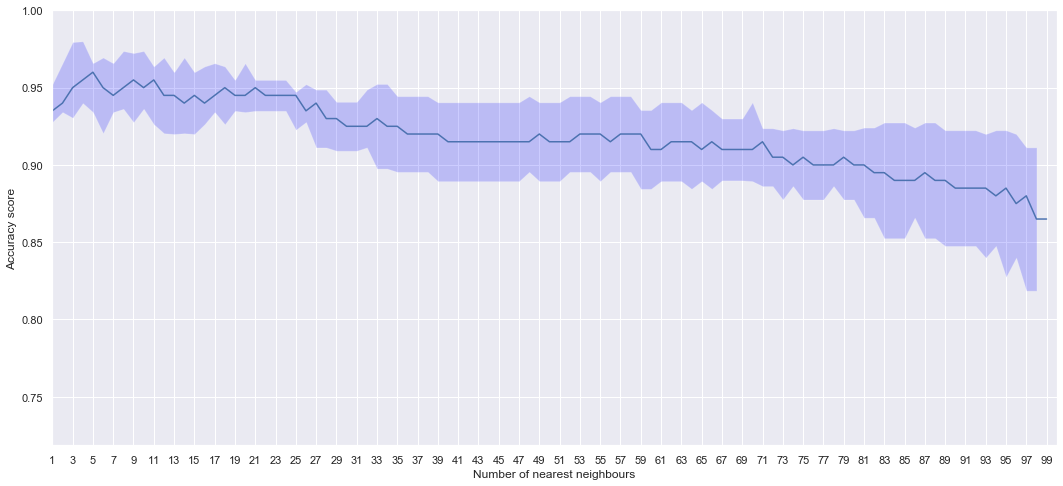

In [23]:
plt.figure(figsize=(18, 8))
plt.plot(n_neighbors, means)
plt.fill_between(range(len(means)), means + stds, means - stds, alpha = 0.2, facecolor='blue')
plt.xlim(1, n)
plt.ylim(np.min(means - stds) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

## Какие параметры ещё можно настраивать?

Помимо числа соседей, мы можем подбирать следующие параметры:

1. weights ('uniform', 'distance', [callable])
2. metric 
3. p (для метрики Минковского)

Кроме того, у KNeighborsClassifier есть параметр algorithm, который отвечает за алгоритм поиска ближайших соседей, который может позволить ускорить работу по сравнению с наивным подходом:

1. Brute force
2. [BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)
3. [KDTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)
4. Auto

При использовании этих алгоритмов появляется и параметр для более детальной их настройки: leaf_size (для BallTree и KDTree)

## Масштабирование признаков

Загрузим набор данных [Wine](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data), где требуется предсказать сорт винограда, из которого изготовлено вино, используя результаты химических анализов. Более подробное описание данных можно посмотреть [здесь](https://archive.ics.uci.edu/ml/datasets/Wine).

In [24]:
data = pd.read_csv('wine.data', header=None)
print(data.shape)
data.head()

(178, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [25]:
data[0].value_counts()

2    71
1    59
3    48
Name: 0, dtype: int64

Сохраним отдельно матрицу объектов и столбец ответов

In [26]:
y = data[0].values
X = data.drop(0, axis=1).values
print(X.shape, y.shape)

(178, 13) (178,)


Подберём число соседей по кроссвалидации. Для этого напишем функцию, которая сделает это за нас

In [27]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def cv_nn(n_neighbors, X, y):
    average_scores = []
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    for k in n_neighbors:
        knn_clf = KNN(n_neighbors=k)
        scores = cross_val_score(knn_clf, X, y, cv=cv)
        average_scores.append(scores.mean())
    return average_scores

In [28]:
n_neighbors = range(1, 51)
average_scores = cv_nn(n_neighbors, X, y)

Посмотрим на то, что получилось:

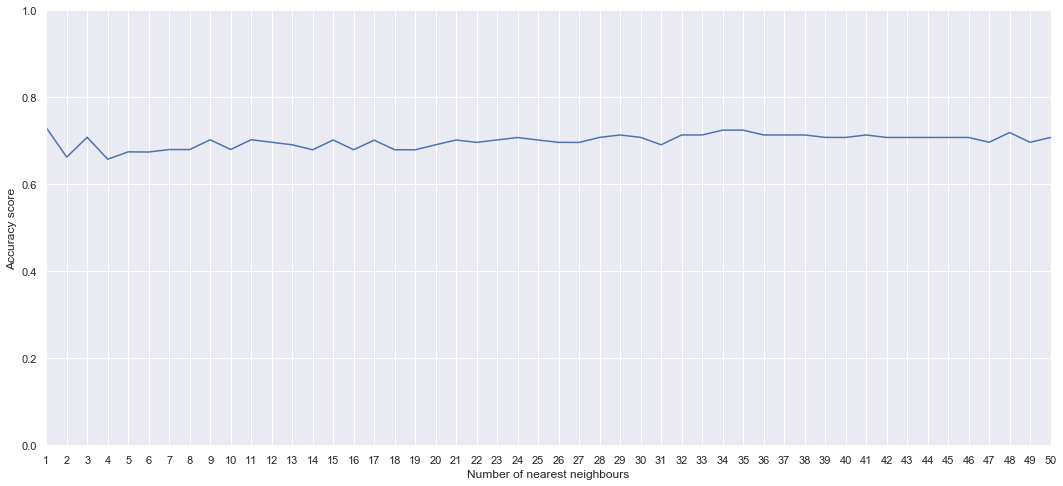

In [29]:
plt.figure(figsize=(18, 8))
l1 = plt.plot(n_neighbors, average_scores)
plt.xticks(n_neighbors)
plt.xlim(np.min(n_neighbors), np.max(n_neighbors))
plt.ylim(0, 1)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

А теперь сперва отмасштабируем данные и проделаем то же самое

In [30]:
from sklearn.preprocessing import scale
X_scaled = scale(X)
average_scores_scaled = cv_nn(n_neighbors, X_scaled, y)

Сравним полученные результаты

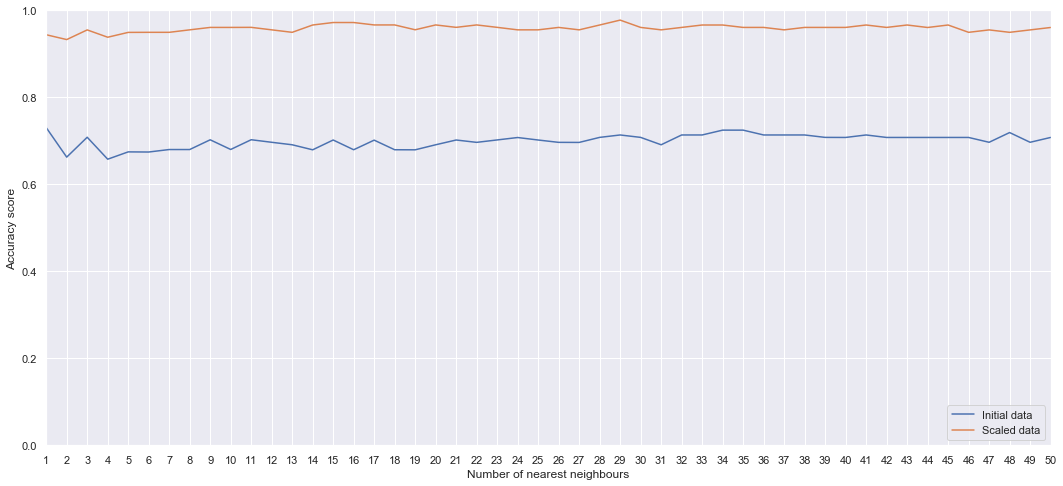

In [31]:
plt.figure(figsize=(18, 8))
l1 = plt.plot(n_neighbors, average_scores)
l2 = plt.plot(n_neighbors, average_scores_scaled)
plt.xticks(n_neighbors)
plt.xlim(np.min(n_neighbors), np.max(n_neighbors))
plt.ylim(0, 1)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.legend(['Initial data', 'Scaled data'], loc='lower right')
plt.grid()

Видно, что масштабирование данных сильно сказалось на качестве классификации.